In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)
pd.options.mode.chained_assignment = None

import random
random.seed(68)

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=20)

from rdkit import Chem


INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from standardization_process import plot_reg_correlation,plot_diagram,unreliable_datapoints,plot_cls_correlation,identify_unreliable_group,final_mean_value
from data_split import train_test_split

In [3]:
def remove_bad_datapoints(df,controlled_list,value_col,fold=np.log10(3)):
    bad_datapoints_index = unreliable_datapoints(df, controlled_list, value_col)
    df = df.loc[~df.index.isin(bad_datapoints_index),] 
    
    bad_group_index = identify_unreliable_group(df, controlled_list, value_col, fold=fold)
    
    df = df.loc[~df.index.isin(bad_group_index),] 
    
    
    return df

In [4]:
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
def compound_property_analysis(mol_list):
    atom_counts = mol_list.map(lambda x: x.GetNumAtoms())
    qed = mol_list.parallel_apply(Descriptors.qed)
    logp = mol_list.parallel_apply(Descriptors.MolLogP)
    TPSA = mol_list.parallel_apply(Descriptors.TPSA)
    HBD = mol_list.parallel_apply(Descriptors.NumHDonors)
    HBA = mol_list.parallel_apply(Descriptors.NumHAcceptors)
    
    fig, axs = plt.subplots(3,2, figsize=(16, 10))

    # Plot data
    axs[0, 0].hist(qed, bins=20, color='b', alpha=0.7, label='A')
    axs[0, 0].set_title('qed')

    axs[0, 1].hist(atom_counts, bins=20, color='r', alpha=0.7, label='B')
    axs[0, 1].set_title('atom_counts')

    axs[1, 0].hist(logp, bins=20, color='g', alpha=0.7, label='C')
    axs[1, 0].set_title('logp')

    axs[1, 1].hist(TPSA, bins=20, color='y', alpha=0.7, label='D')
    axs[1, 1].set_title('TPSA')

    axs[2, 0].hist(HBD, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 0].set_title('HBD')

    axs[2, 1].hist(HBA, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 1].set_title('HBA')

    # Add some labels and titles for better readability
    for ax in axs.flat:
        ax.set( ylabel='Frequency')


    plt.show()

# Load data

In [5]:
all_data = pd.read_csv('../data/data_processing_result/ppb_preprocessing_finished.csv')

In [6]:
all_data.head()

,Smiles_unify,Smiles,value,source,concentration,spec,property
0,Nc1noc2ccc(-n3nc(C(F)(F)F)c4c3C(=O)N(c3ccc(-c5...,Nc1noc2ccc(-n3nc(C(F)(F)F)c4c3C(=O)N(c3ccc(-c5...,97.0,CHEMBL900675,NaN,Human Serum,ppb
1,COc1cc(NC(C(=O)c2c[nH]c3ccccc23)c2ccccc2)cc(OC...,COc1cc(NC(C(=O)c2c[nH]c3ccccc23)c2ccccc2)cc(OC...,99.0,CHEMBL4200986,NaN,Human,ppb
2,O=C(O)C[C@H](NC(=O)Cn1c(C2CC2)cnc(NCc2ccc3c(n2...,O=C(O)C[C@H](NC(=O)Cn1c(C2CC2)cnc(NCc2ccc3c(n2...,97.5,CHEMBL619354,NaN,Human,ppb
3,CN1CCN(Nc2ncc(Nc3ccc4c(Nc5cnccn5)ccnc4c3)cn2)CC1,CN1CCN(Nc2ncc(Nc3ccc4c(Nc5cnccn5)ccnc4c3)cn2)CC1,51.0,CHEMBL4373163,NaN,Human,ppb
4,N#Cc1cc(F)cc(Oc2ccc3c(c2C(F)F)[C@@H](O)C(F)(F)...,N#Cc1cc(F)cc(Oc2ccc3c(c2C(F)F)[C@@H](O)C(F)(F)...,63.0,CHEMBL4158411,10 uM,Human Plasma,ppb


<AxesSubplot:>

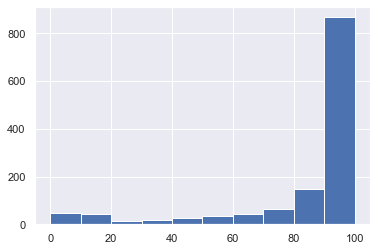

In [7]:
all_data['value'].hist()

In [8]:
all_data

,Smiles_unify,Smiles,value,source,concentration,spec,property
0,Nc1noc2ccc(-n3nc(C(F)(F)F)c4c3C(=O)N(c3ccc(-c5...,Nc1noc2ccc(-n3nc(C(F)(F)F)c4c3C(=O)N(c3ccc(-c5...,97.0,CHEMBL900675,NaN,Human Serum,ppb
1,COc1cc(NC(C(=O)c2c[nH]c3ccccc23)c2ccccc2)cc(OC...,COc1cc(NC(C(=O)c2c[nH]c3ccccc23)c2ccccc2)cc(OC...,99.0,CHEMBL4200986,NaN,Human,ppb
2,O=C(O)C[C@H](NC(=O)Cn1c(C2CC2)cnc(NCc2ccc3c(n2...,O=C(O)C[C@H](NC(=O)Cn1c(C2CC2)cnc(NCc2ccc3c(n2...,97.5,CHEMBL619354,NaN,Human,ppb
3,CN1CCN(Nc2ncc(Nc3ccc4c(Nc5cnccn5)ccnc4c3)cn2)CC1,CN1CCN(Nc2ncc(Nc3ccc4c(Nc5cnccn5)ccnc4c3)cn2)CC1,51.0,CHEMBL4373163,NaN,Human,ppb
4,N#Cc1cc(F)cc(Oc2ccc3c(c2C(F)F)[C@@H](O)C(F)(F)...,N#Cc1cc(F)cc(Oc2ccc3c(c2C(F)F)[C@@H](O)C(F)(F)...,63.0,CHEMBL4158411,10 uM,Human Plasma,ppb
...,...,...,...,...,...,...,...
1305,C#CCOc1ncc(F)c(OCC#C)n1,C#CCOc1ncc(F)c(OCC#C)n1,85.8,CHEMBL5156881,5 uM,Human Plasma,ppb
1306,CCOc1ccccc1NC(=O)c1cc(C)ccc1NS(=O)(=O)C1CC1,CCOc1ccccc1NC(=O)c1cc(C)ccc1NS(=O)(=O)C1CC1,0.3,CHEMBL5167414,NaN,Human,ppb
1307,CCOc1ccc(F)cc1NC(=O)c1cc(Cl)ccc1NS(=O)(=O)C1CC1,CCOc1ccc(F)cc1NC(=O)c1cc(Cl)ccc1NS(=O)(=O)C1CC1,0.1,CHEMBL5167414,NaN,Human,ppb
1308,COc1ccc2ccc(=O)n(CCN[C@H]3CC[C@H]4[C@@H](C3)OC...,COc1ccc2ccc(=O)n(CCN[C@H]3CC[C@H]4[C@@H](C3)OC...,8.1,CHEMBL5146138,NaN,Human,ppb


### Repeated values

In [9]:
controlled_variable = ['Smiles_unify']

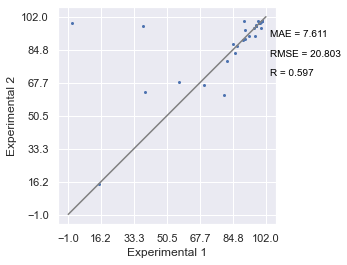

In [10]:
plot_diagram(all_data, controlled_variable, 'value')

# Further filtering

In [11]:
df_remove_bad_datapoints = remove_bad_datapoints(all_data,controlled_variable, 'value',fold=50)

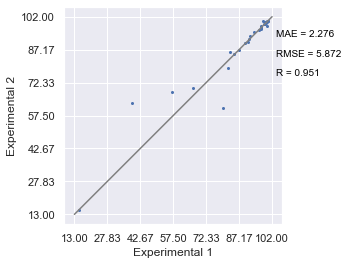

In [12]:
plot_diagram(df_remove_bad_datapoints, controlled_variable, 'value')

In [13]:
df = final_mean_value(df_remove_bad_datapoints,controlled_variable, 'value')

In [14]:
df['value'] = df['value_mean'].copy()

In [15]:
df = df.drop_duplicates(controlled_variable)

In [16]:
df.columns

Index(['Smiles_unify', 'Smiles', 'value', 'source', 'concentration', 'spec',
       'property', 'value_mean'],
      dtype='object')

# Compound Property analysis

In [17]:
df['value'] = df['value']/100

In [20]:
df = df[['Smiles_unify','value','property']]

In [21]:
mol_list = df['Smiles_unify'].map(Chem.MolFromSmiles)

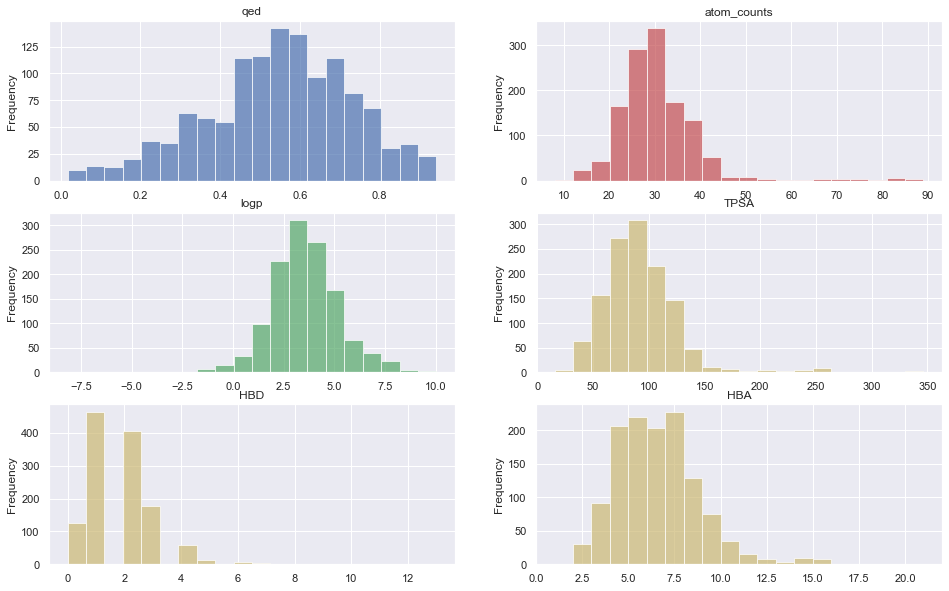

In [22]:
compound_property_analysis(mol_list)

# Data Split

In [23]:
df =  df.reset_index()


train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=True)
df.loc[train_index,'scaffold_train_test_label'] = 'train'
df.loc[test_index,'scaffold_train_test_label'] = 'test'

train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=False)
df.loc[train_index,'random_train_test_label'] = 'train'
df.loc[test_index,'random_train_test_label'] = 'test'

100%|█████████████████████████████████████| 1262/1262 [00:00<00:00, 7882.54it/s]


In [25]:
df[['Smiles_unify',  'value', 'property', 'scaffold_train_test_label','random_train_test_label']].to_csv('../data/final_datasets/ppb_reg_final_data.csv',index=False)

In [26]:
df.shape

(1262, 6)

<AxesSubplot:>

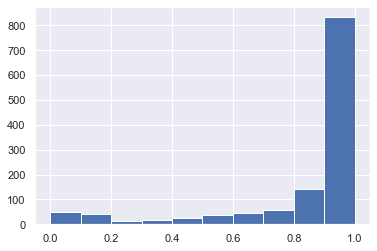

In [28]:
df['value'].hist()
